# Separate Light profile

#### First import modules ####

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting

from dysmalpy.fitting_wrappers import tied_functions

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

##### Setup notebook #####

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

In [4]:
from importlib import reload

-----------

## Gaussian Ring: If flux profile right?

In [5]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [9]:
GR = models.LightGaussianRing(r_peak=5., sigma_r =1., L_tot=1.)

In [10]:
r = np.arange(0.,20.1,0.1)

In [11]:
Lr = GR(r)

In [12]:
np.sum(2.*np.pi*r*Lr*(r[1]-r[0]))

0.9999999997551636

In [13]:
I0 = models._I0_gaussring(GR.r_peak.value, GR.sigma_r.value, GR.L_tot.value)

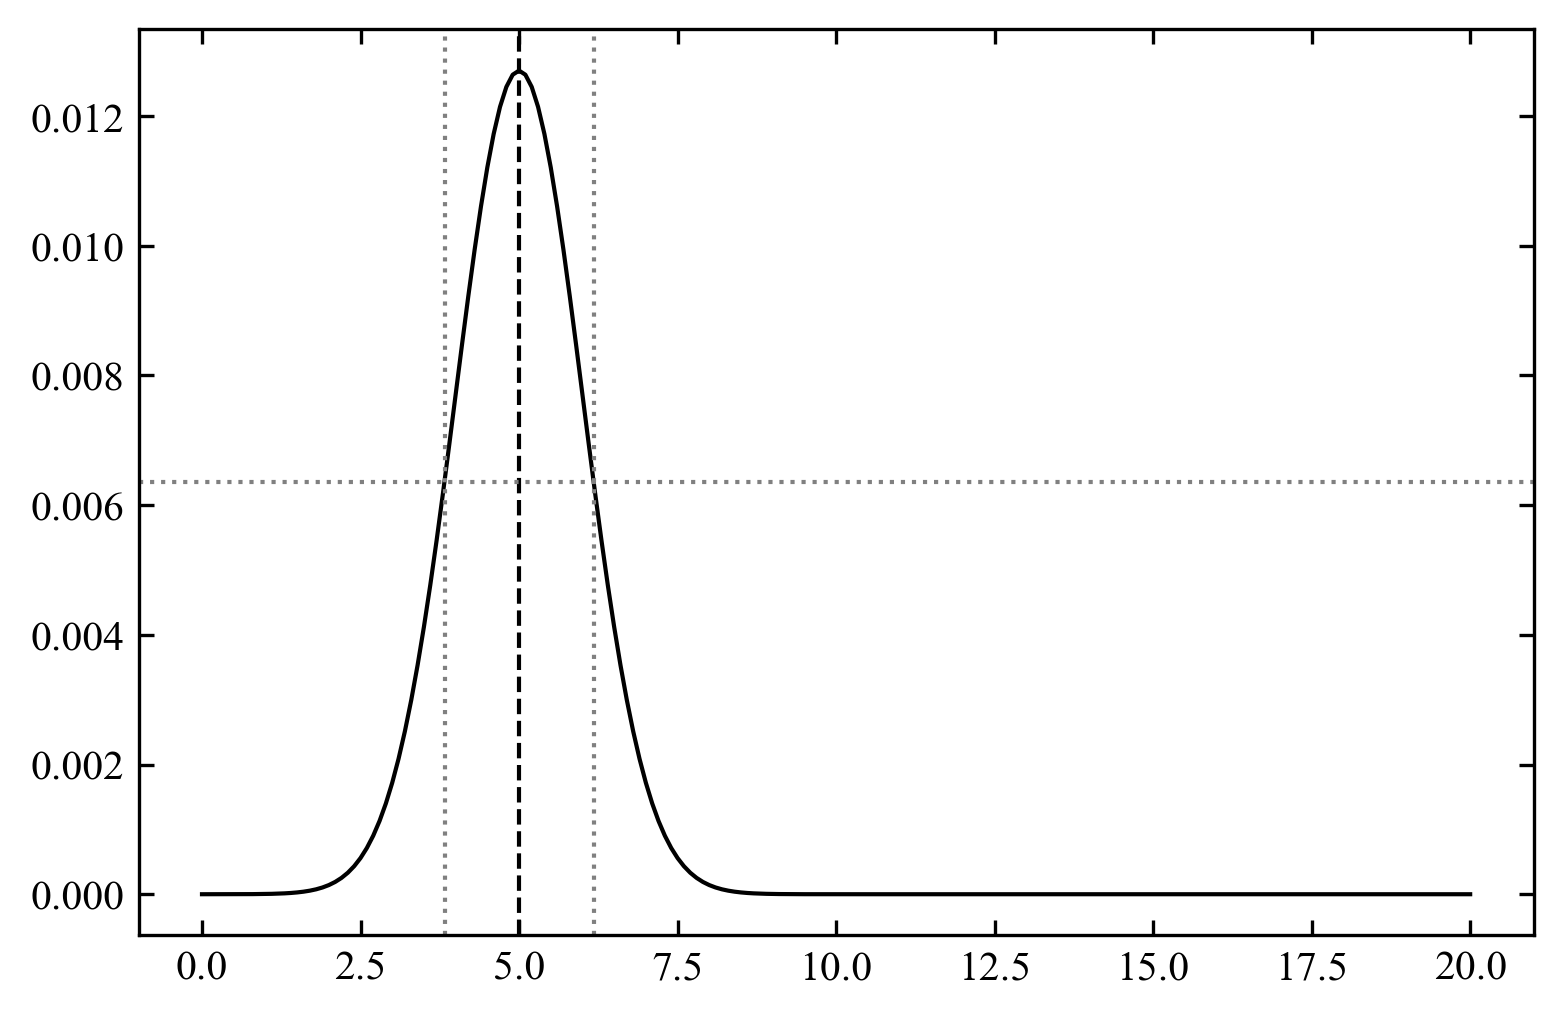

In [14]:
plt.plot(r, Lr, color='black')
plt.gca().axvline(x=GR.r_peak.value, ls='--', color='k')
plt.gca().axvline(x=GR.r_peak.value-2.35*GR.sigma_r.value/2., ls=':', color='grey')
plt.gca().axvline(x=GR.r_peak.value+2.35*GR.sigma_r.value/2., ls=':', color='grey')
plt.gca().axhline(y=0.5*I0, ls=':', color='grey')

## Truncated Sersic: If flux profile right?

In [15]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [16]:
TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., r_inner=1., r_outer=10.)
Sersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1.)

In [17]:
r = np.arange(0.,20.1,0.1)

In [18]:
TLr = TSersic(r)
SLr = Sersic(r)

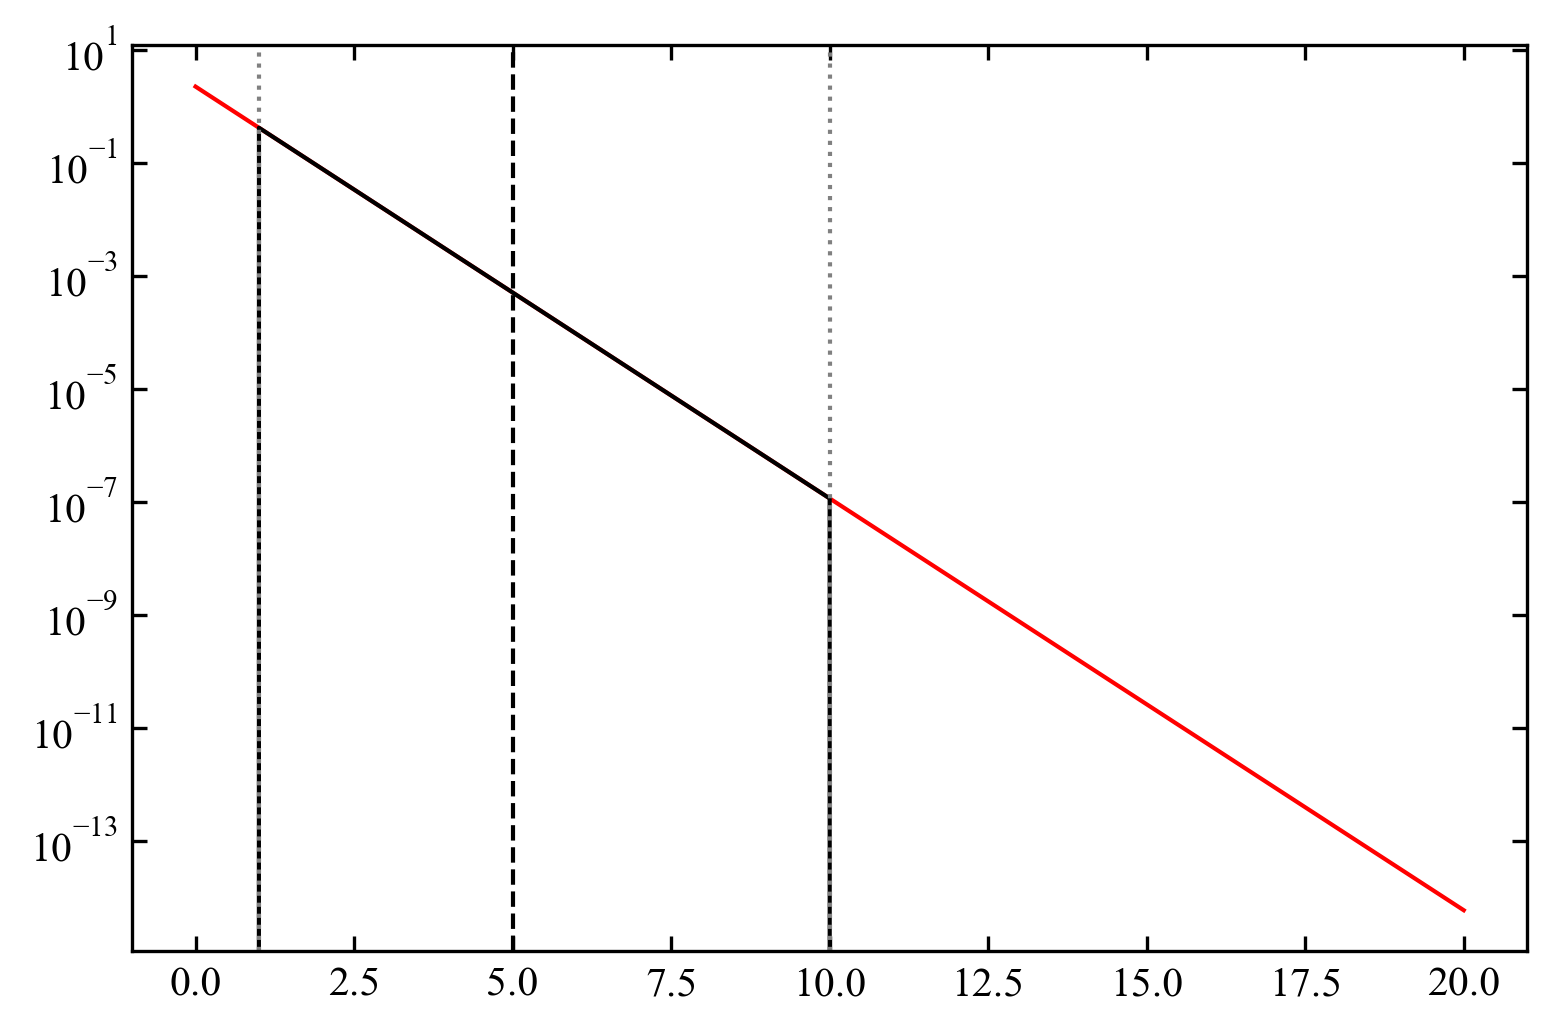

In [19]:
plt.plot(r, SLr, color='red')
plt.plot(r, TLr, color='black')
plt.gca().axvline(x=TSersic.r_eff.value, ls='--', color='k')
plt.gca().axvline(x=TSersic.r_inner.value, ls=':', color='grey')
plt.gca().axvline(x=TSersic.r_outer.value, ls=':', color='grey')
plt.gca().set_yscale('log')

In [20]:
TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., r_inner=1., r_outer=10.)
Sersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1.)

In [21]:
r = np.arange(0.,20.1,0.1)

In [22]:
TLr = TSersic.mass_to_light(r)
SLr = Sersic.mass_to_light(r)

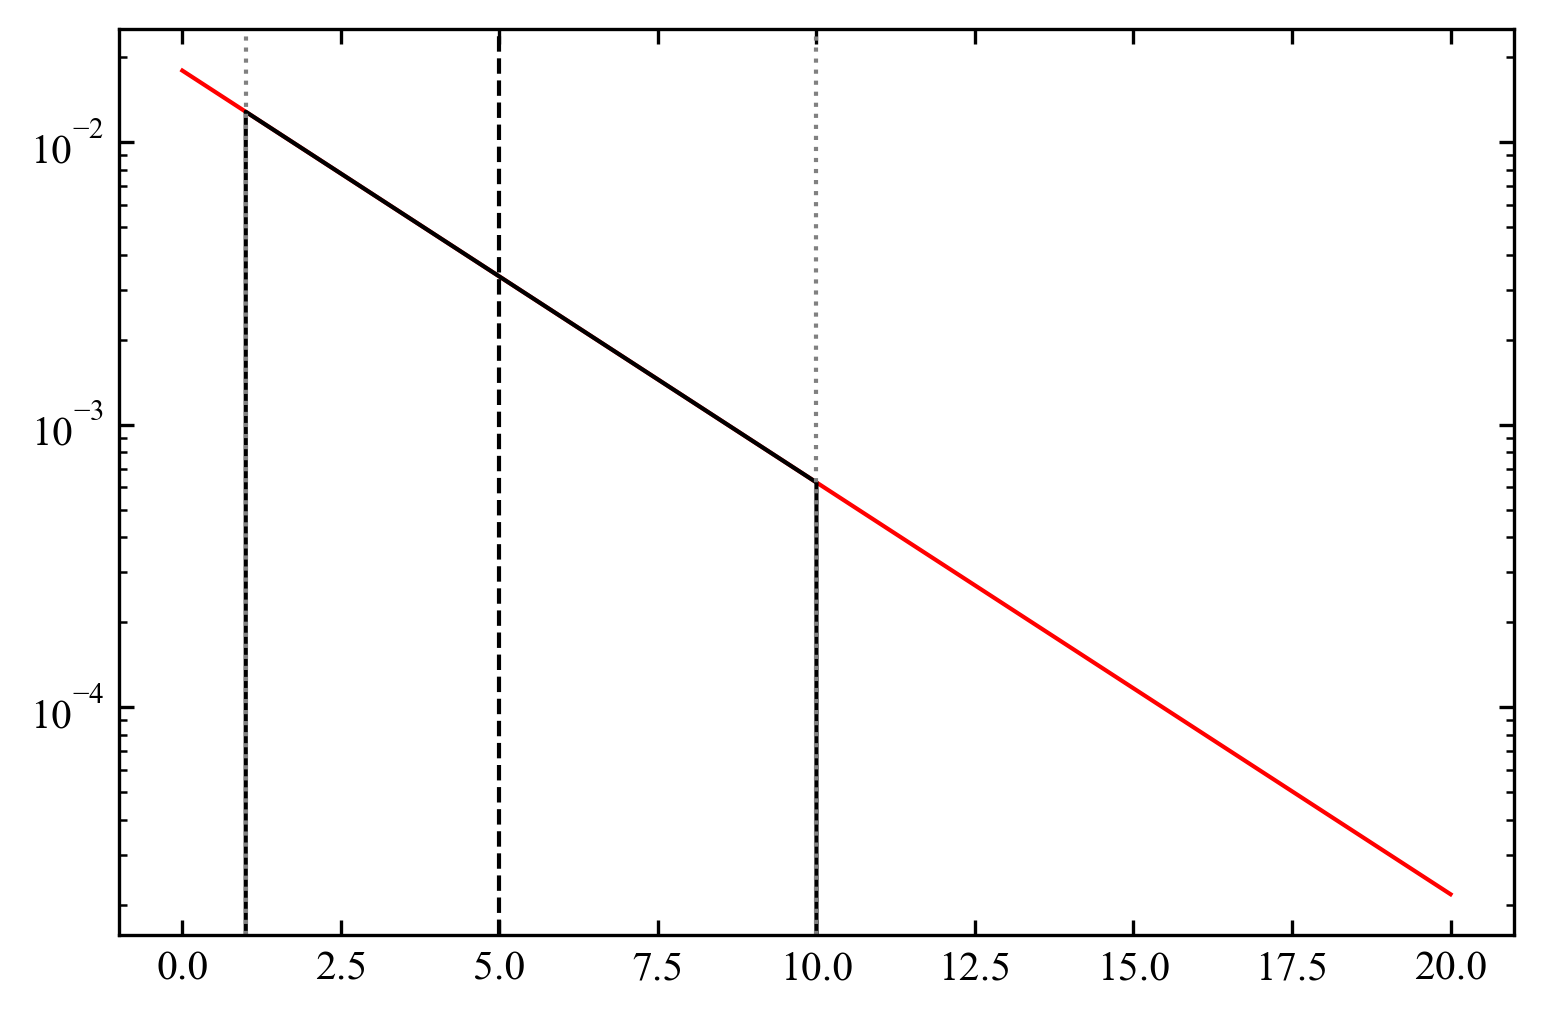

In [23]:
plt.plot(r, SLr, color='red')
plt.plot(r, TLr, color='black')
plt.gca().axvline(x=TSersic.r_eff.value, ls='--', color='k')
plt.gca().axvline(x=TSersic.r_inner.value, ls=':', color='grey')
plt.gca().axvline(x=TSersic.r_outer.value, ls=':', color='grey')
plt.gca().set_yscale('log')

## Test Mass profile vs light profile:

### Hack 1: BH with Sersic=1

In [24]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [25]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [26]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [27]:
BH = models.BlackHole(BH_mass=9.,name='BH')
LSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., name='LSersic')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [28]:
sigmaz = 1.   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [29]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [30]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [31]:
mod_setFO.add_component(BH)
mod_setFO.add_component(LSersic, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [32]:
mod_setEO.add_component(BH)
mod_setEO.add_component(LSersic, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

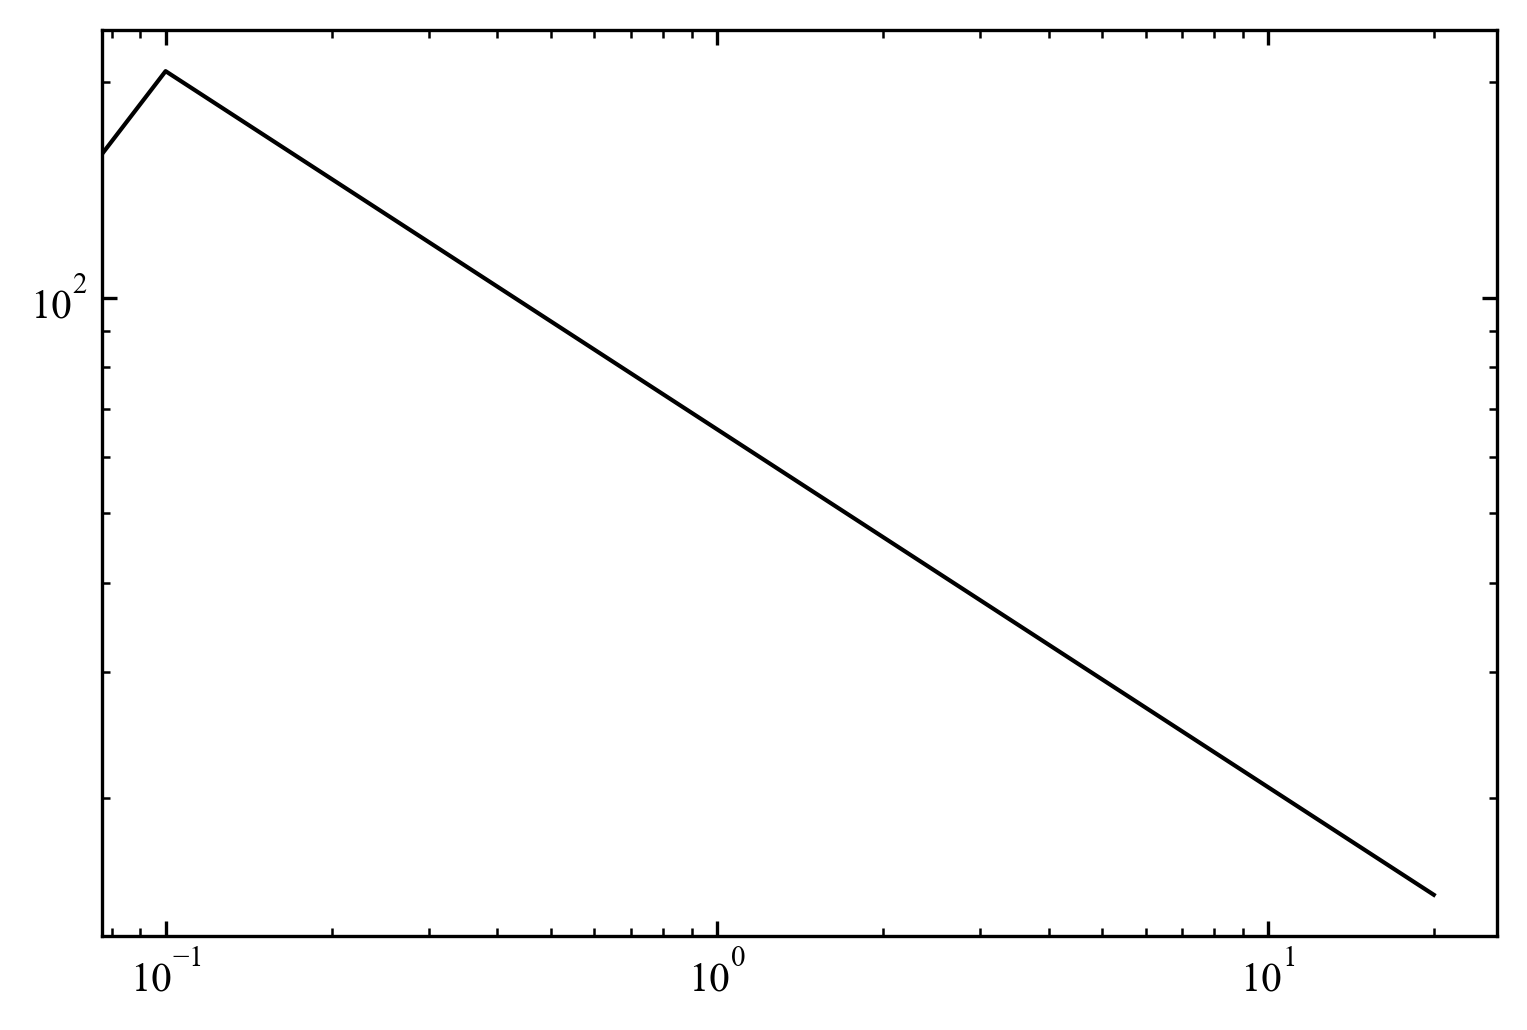

In [33]:
r = np.arange(0.,20.1,0.1)
vc = galEO.model.circular_velocity(r)
vcBH = BH.circular_velocity(r)
vc[r == 0.] = 0.
vcBH[r==0.] = 0.
plt.plot(r, vc, color='black')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

(0.0, 50.0)

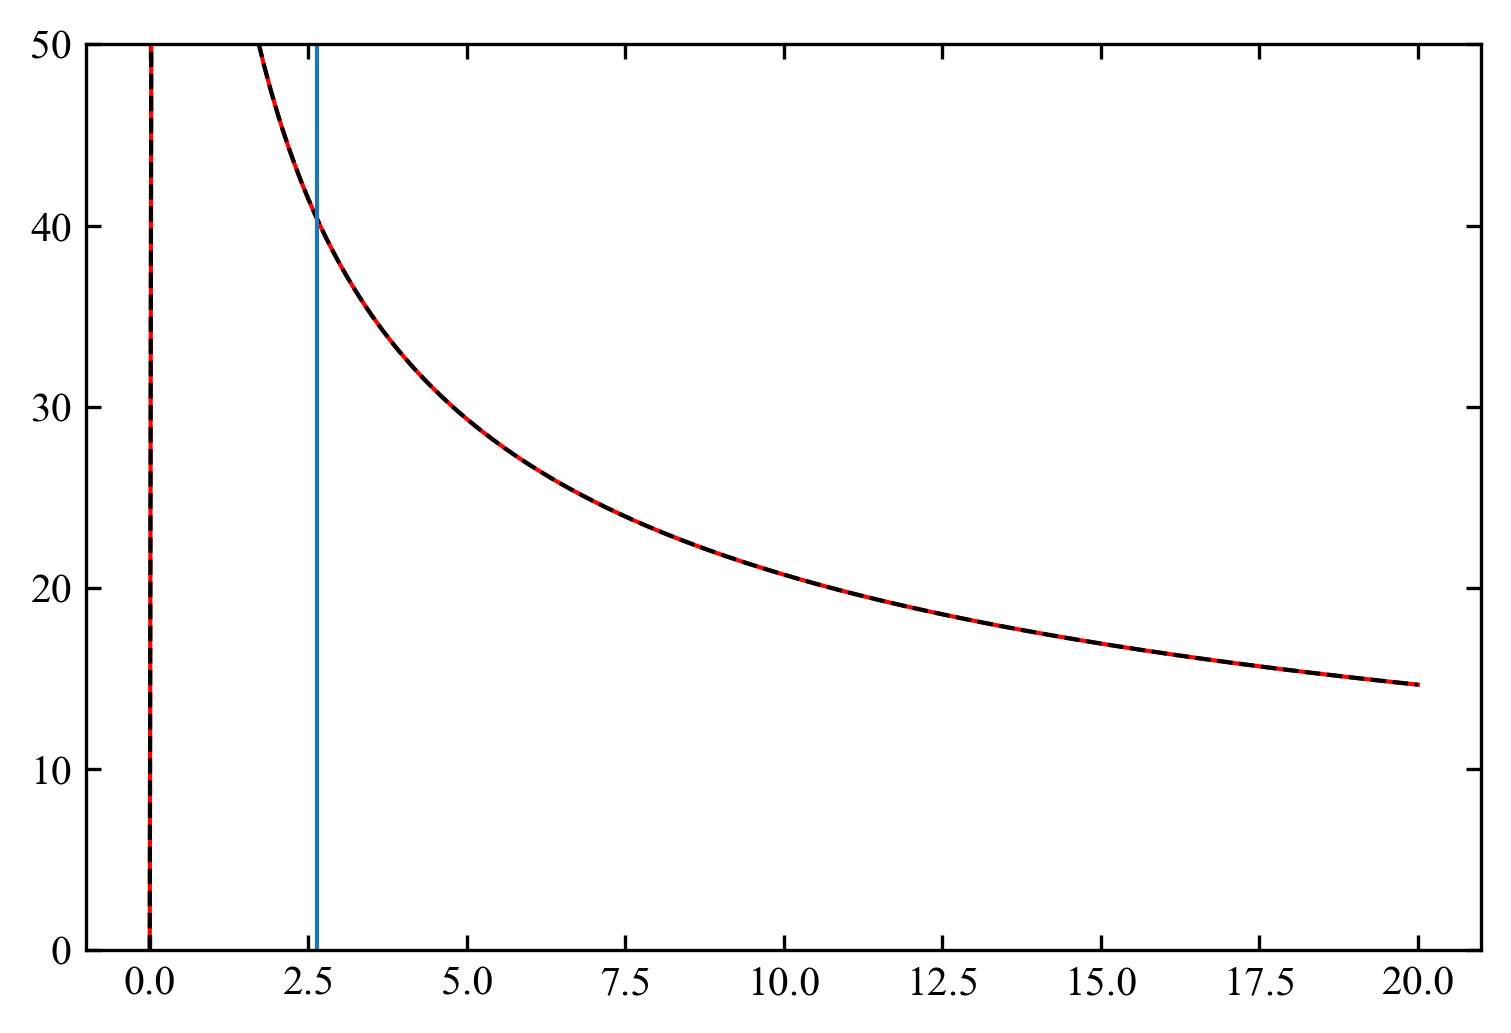

In [34]:
r = np.arange(0.,20.1,0.1)
vc = galEO.model.circular_velocity(r)
vcBH = BH.circular_velocity(r)
vc[r == 0.] = 0.
vcBH[r==0.] = 0.
plt.plot(r, vcBH, color='red')
plt.plot(r, vc, color='black', ls='--')
plt.gca().axvline(8.*0.33)
plt.gca().set_ylim([0., 50.])

In [35]:
beamsize = 0.1*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

beam = None
lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # # Set the beam kernel so it doesn't have to be calculated every step
# inst.set_beam_kernel()
# inst.set_lsf_kernel()

In [36]:
galFO.instrument = inst
galEO.instrument = inst

In [40]:
galFO.model.light_components

OrderedDict([('BH', False),
             ('LSersic', True),
             ('dispprof', False),
             ('zheightgaus', False),
             ('geom', False)])

### 1D model

In [161]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

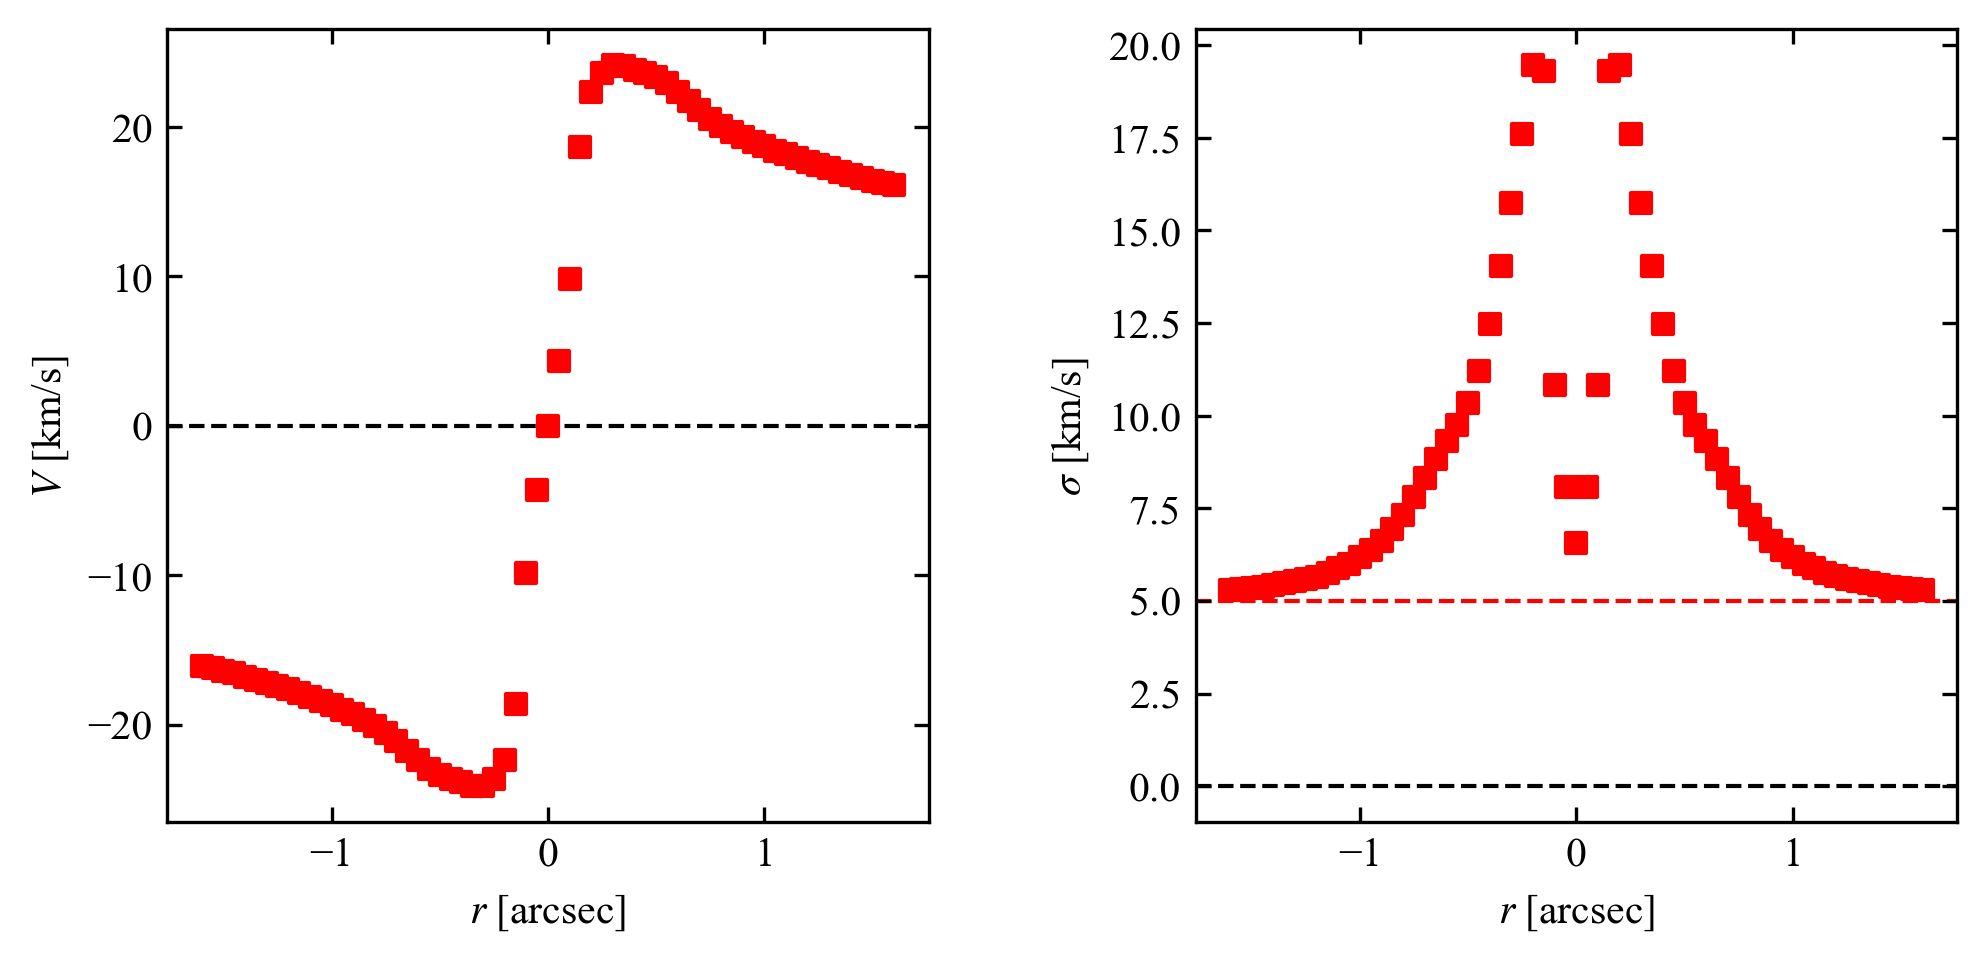

In [162]:
plotting.plot_model_1D(galEO, inst_corr=False, best_dispersion=sigma0)

### 2D model

In [163]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

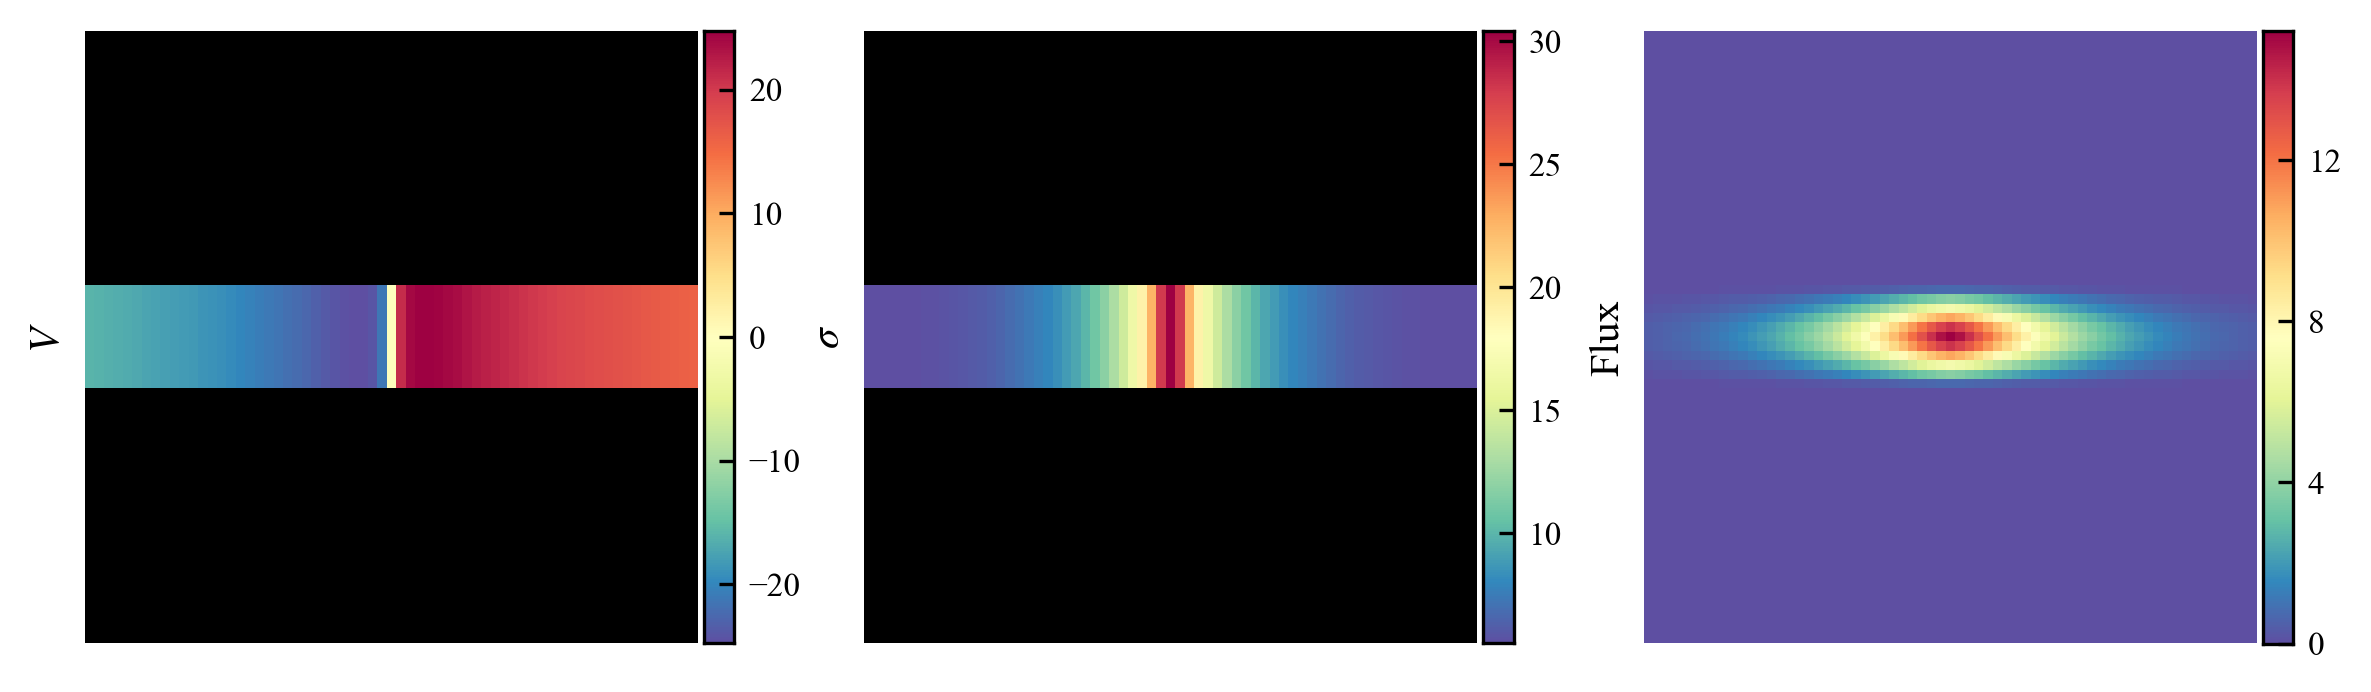

In [164]:
plotting.plot_model_2D(galEO, inst_corr=False, fitflux=True)

### 2D model

In [165]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

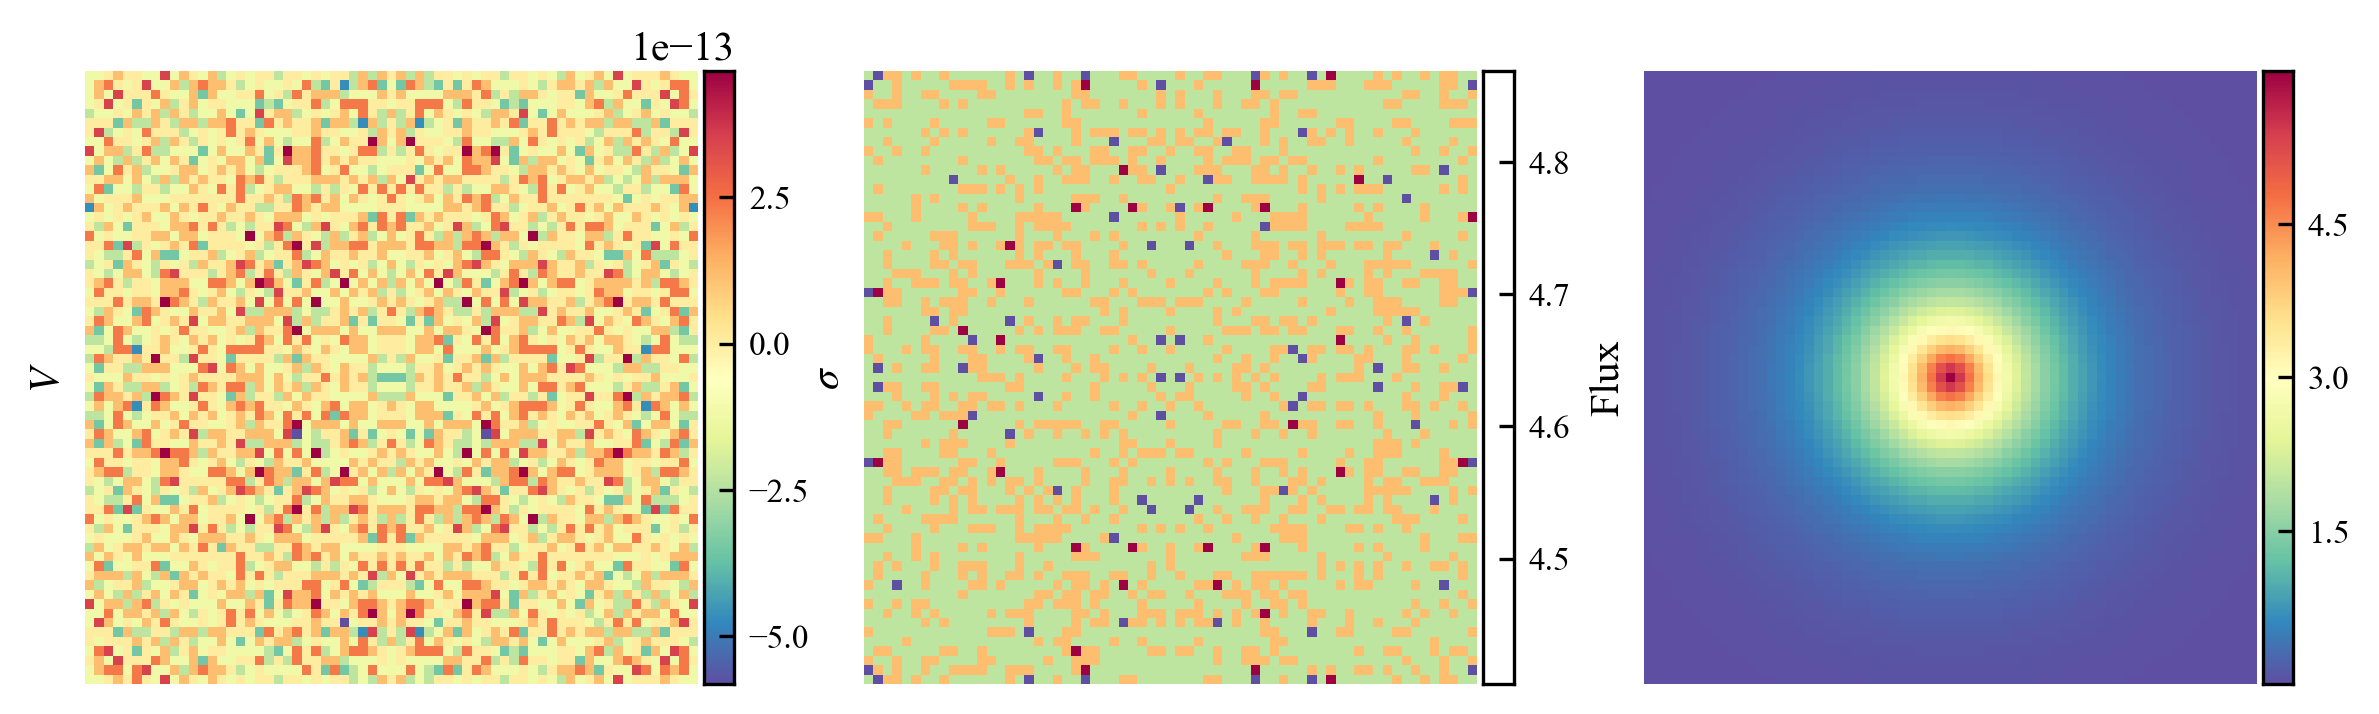

In [166]:
plotting.plot_model_2D(galFO, inst_corr=False, fitflux=True)

---------

--------

### Hack 2: BH with LSersic=1, truncated

In [188]:
reload(models)
reload(galaxy)

<module 'dysmalpy.galaxy' from '/Users/sedona/software_public/dysmalpy/dysmalpy/galaxy.py'>

In [189]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [190]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [191]:
BH = models.BlackHole(BH_mass=9.,name='BH')
TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., 
                                     r_inner=5., r_outer=10., name='TSersic')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [192]:
sigmaz = 1.   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [193]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [194]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [195]:
mod_setFO.add_component(BH)
mod_setFO.add_component(TSersic, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [196]:
mod_setEO.add_component(BH)
mod_setEO.add_component(TSersic, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [197]:
beamsize = 0.1*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

beam = None
lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # # Set the beam kernel so it doesn't have to be calculated every step
# inst.set_beam_kernel()
# inst.set_lsf_kernel()

In [198]:
galFO.instrument = inst
galEO.instrument = inst

### 1D model

In [199]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

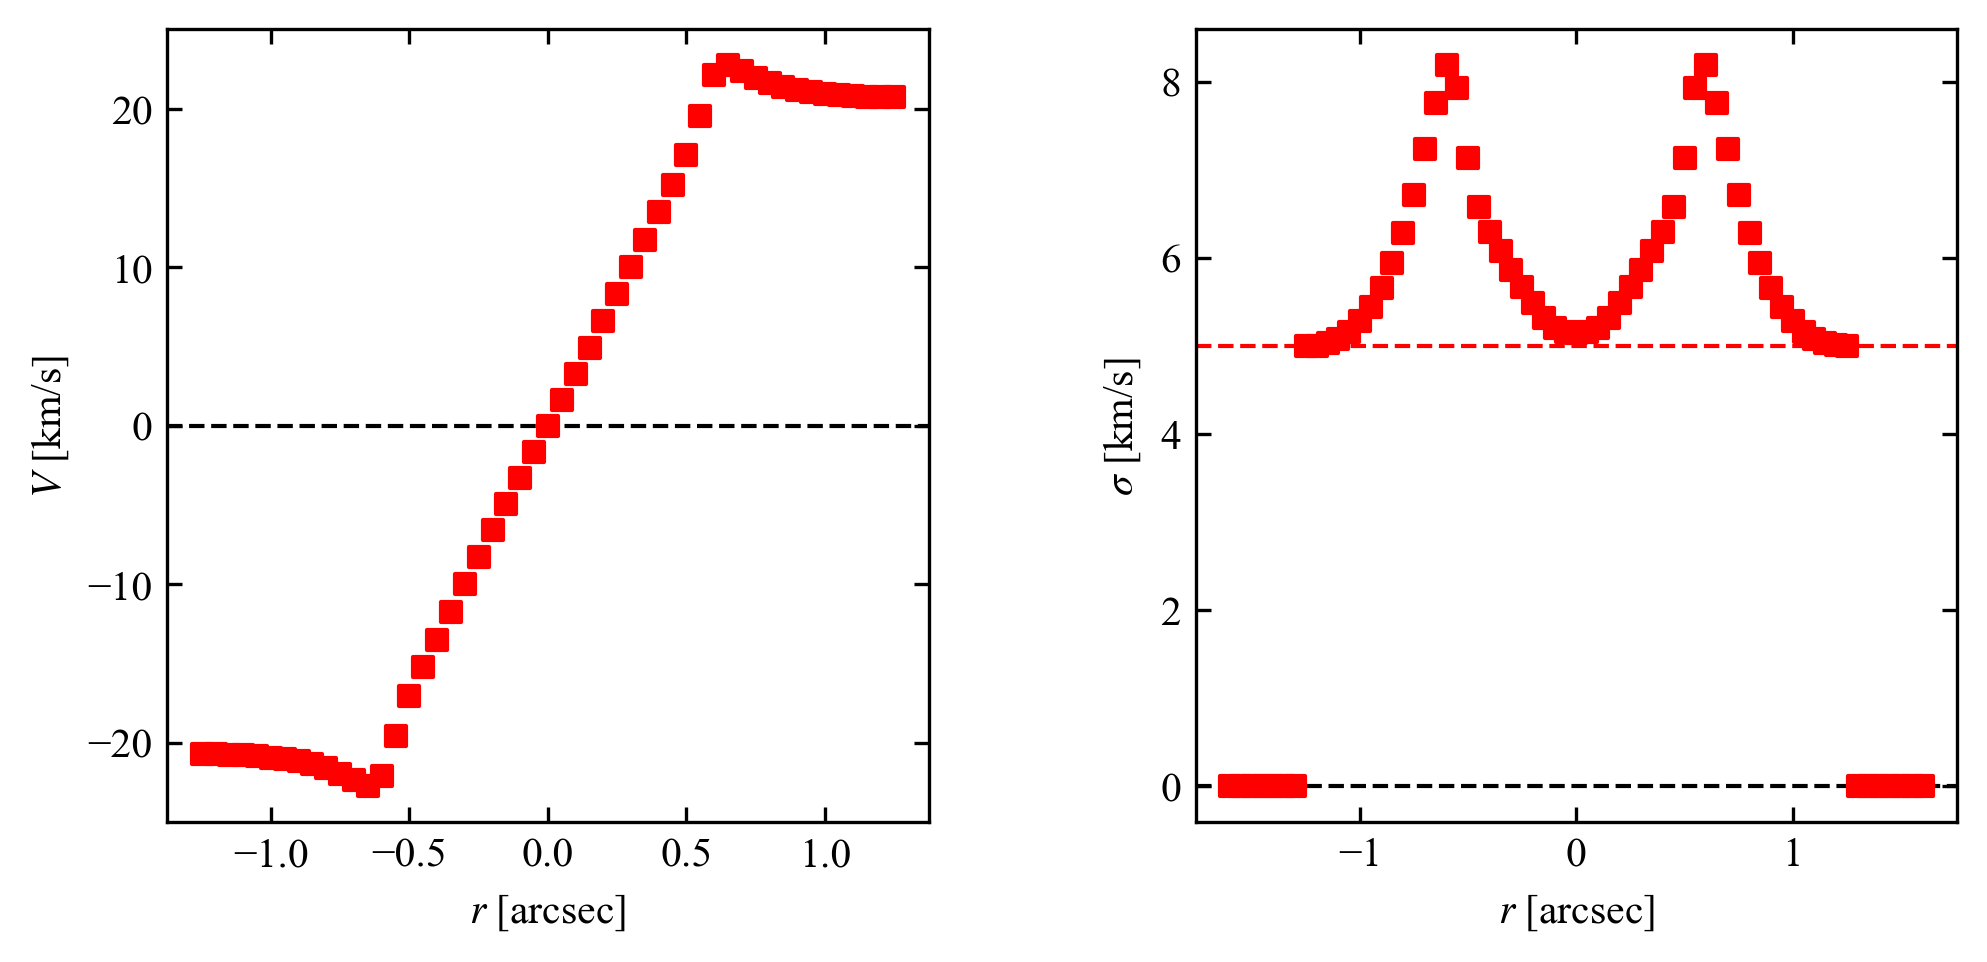

In [200]:
plotting.plot_model_1D(galEO, inst_corr=False, best_dispersion=sigma0)

### 2D model

In [201]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

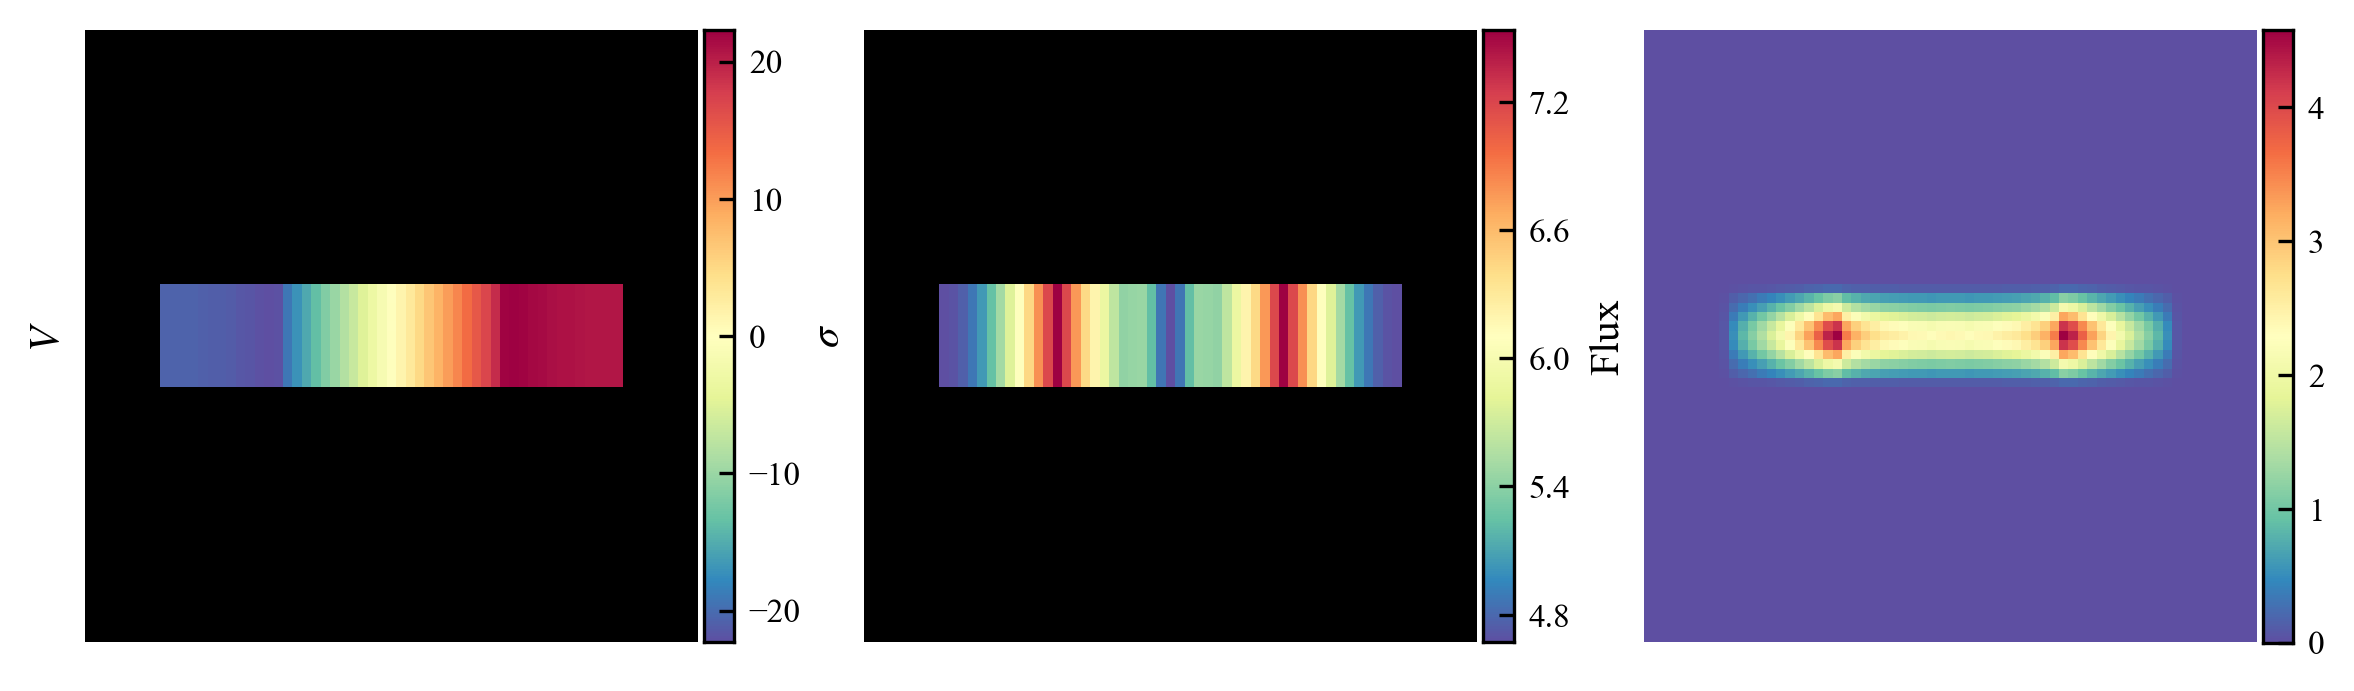

In [202]:
plotting.plot_model_2D(galEO, inst_corr=False, fitflux=True)

### 2D model

In [203]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

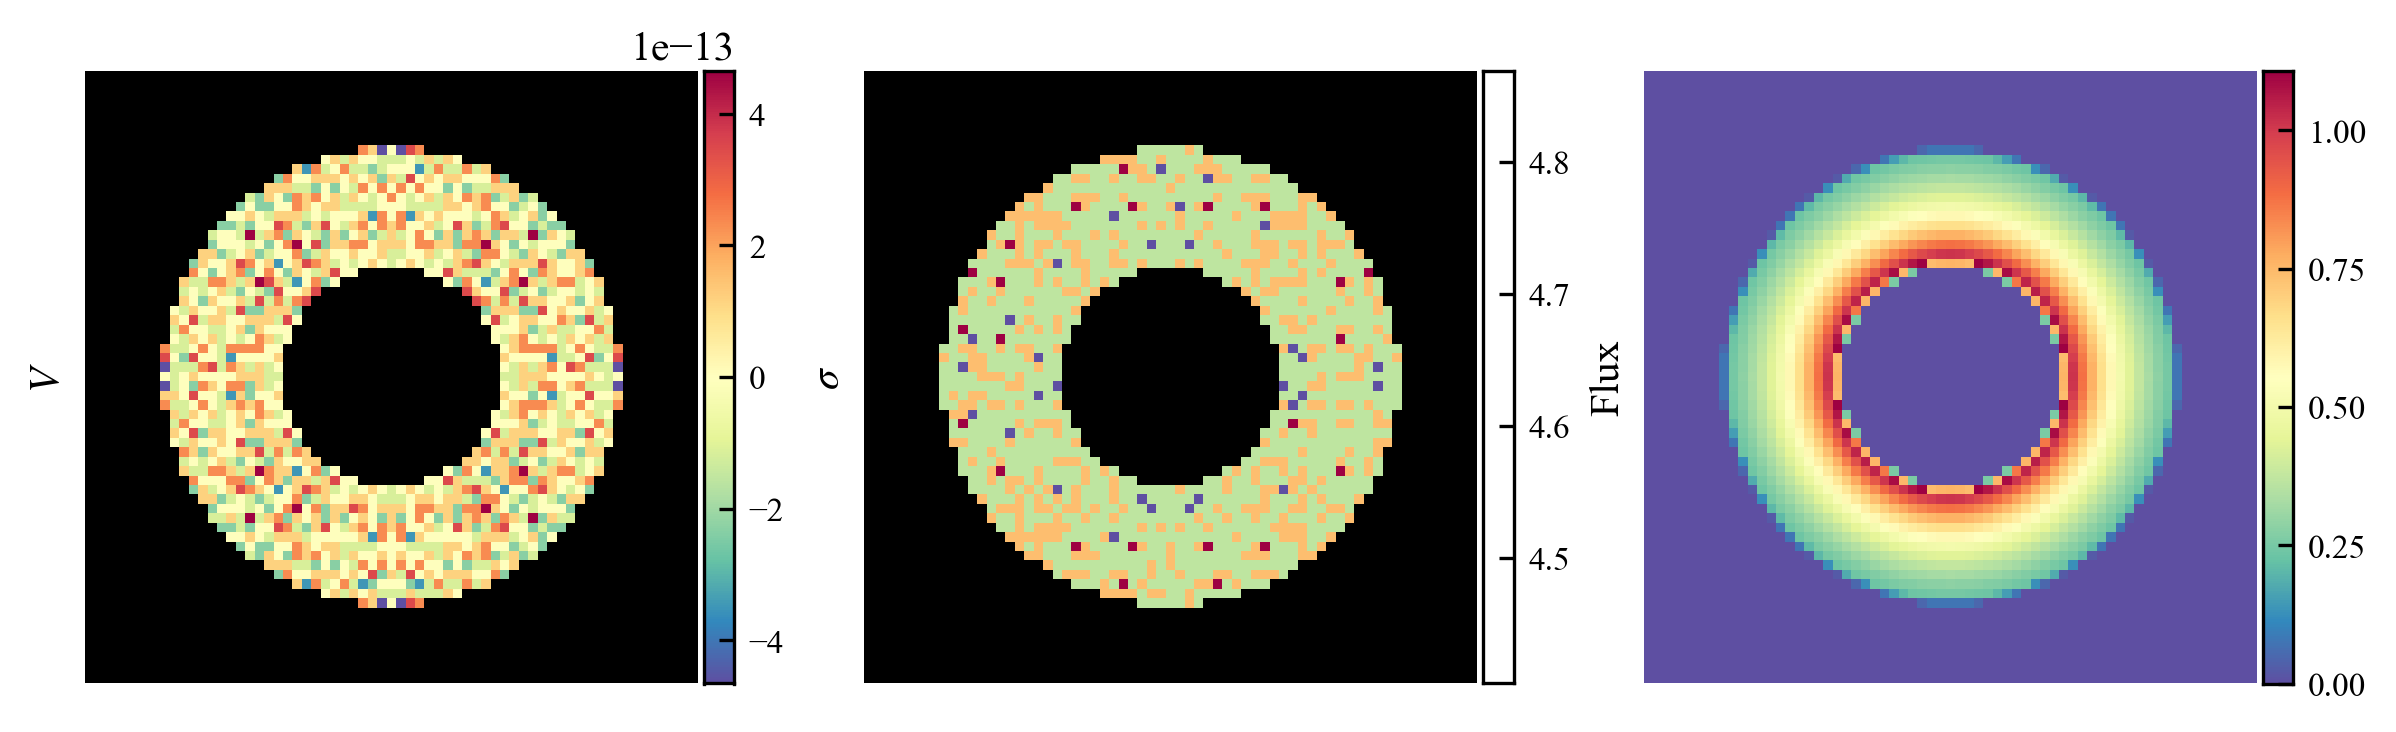

In [204]:
plotting.plot_model_2D(galFO, inst_corr=False, fitflux=True)

---------

--------

### Hack 3: BH with GaussianRing

In [237]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [238]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [239]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [240]:
BH = models.BlackHole(BH_mass=9.,name='BH')
GR = models.LightGaussianRing(r_peak=5., sigma_r =1., L_tot=1., name='GaussianRing')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [241]:
sigmaz = 1.  # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [242]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [243]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [244]:
mod_setFO.add_component(BH)
mod_setFO.add_component(GR, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [245]:
mod_setEO.add_component(BH)
mod_setEO.add_component(GR, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [246]:
beamsize = 0.1*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

beam = None
lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # # Set the beam kernel so it doesn't have to be calculated every step
# inst.set_beam_kernel()
# inst.set_lsf_kernel()

In [247]:
galFO.instrument = inst
galEO.instrument = inst

### 1D model

In [248]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

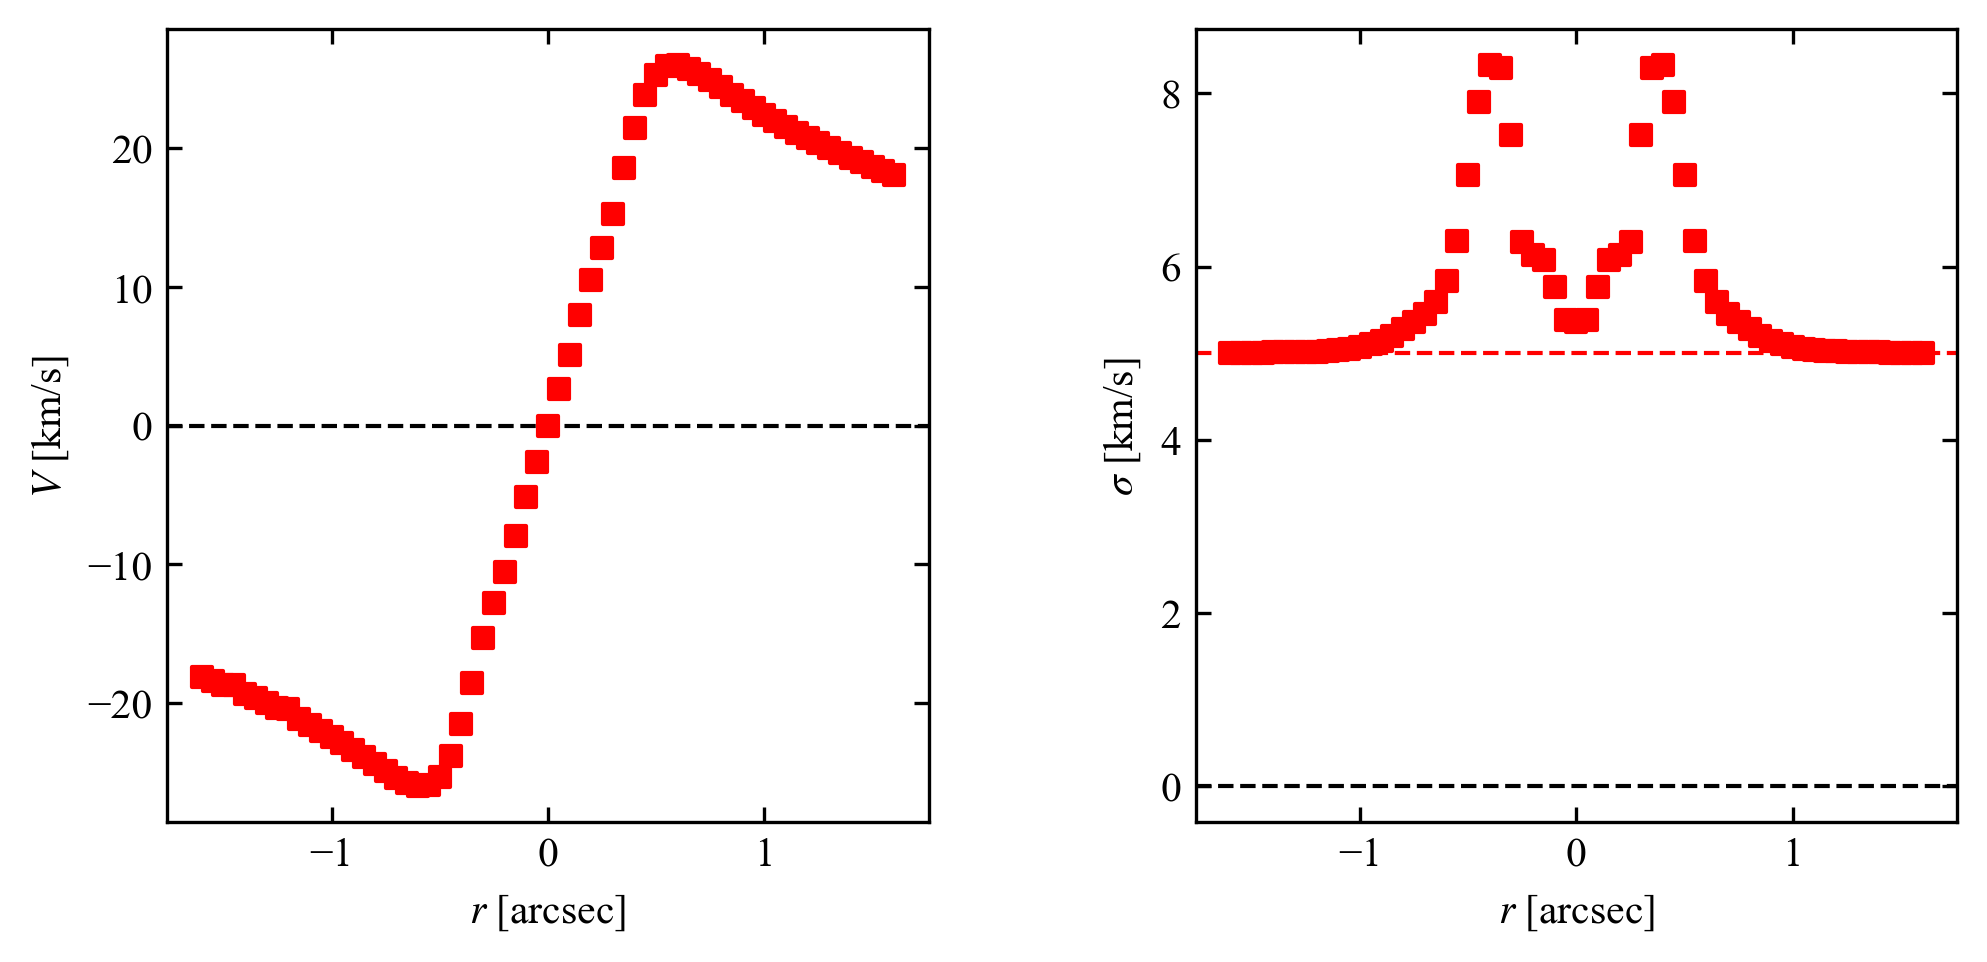

In [249]:
plotting.plot_model_1D(galEO, inst_corr=False, best_dispersion=sigma0)

### 2D model

In [250]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

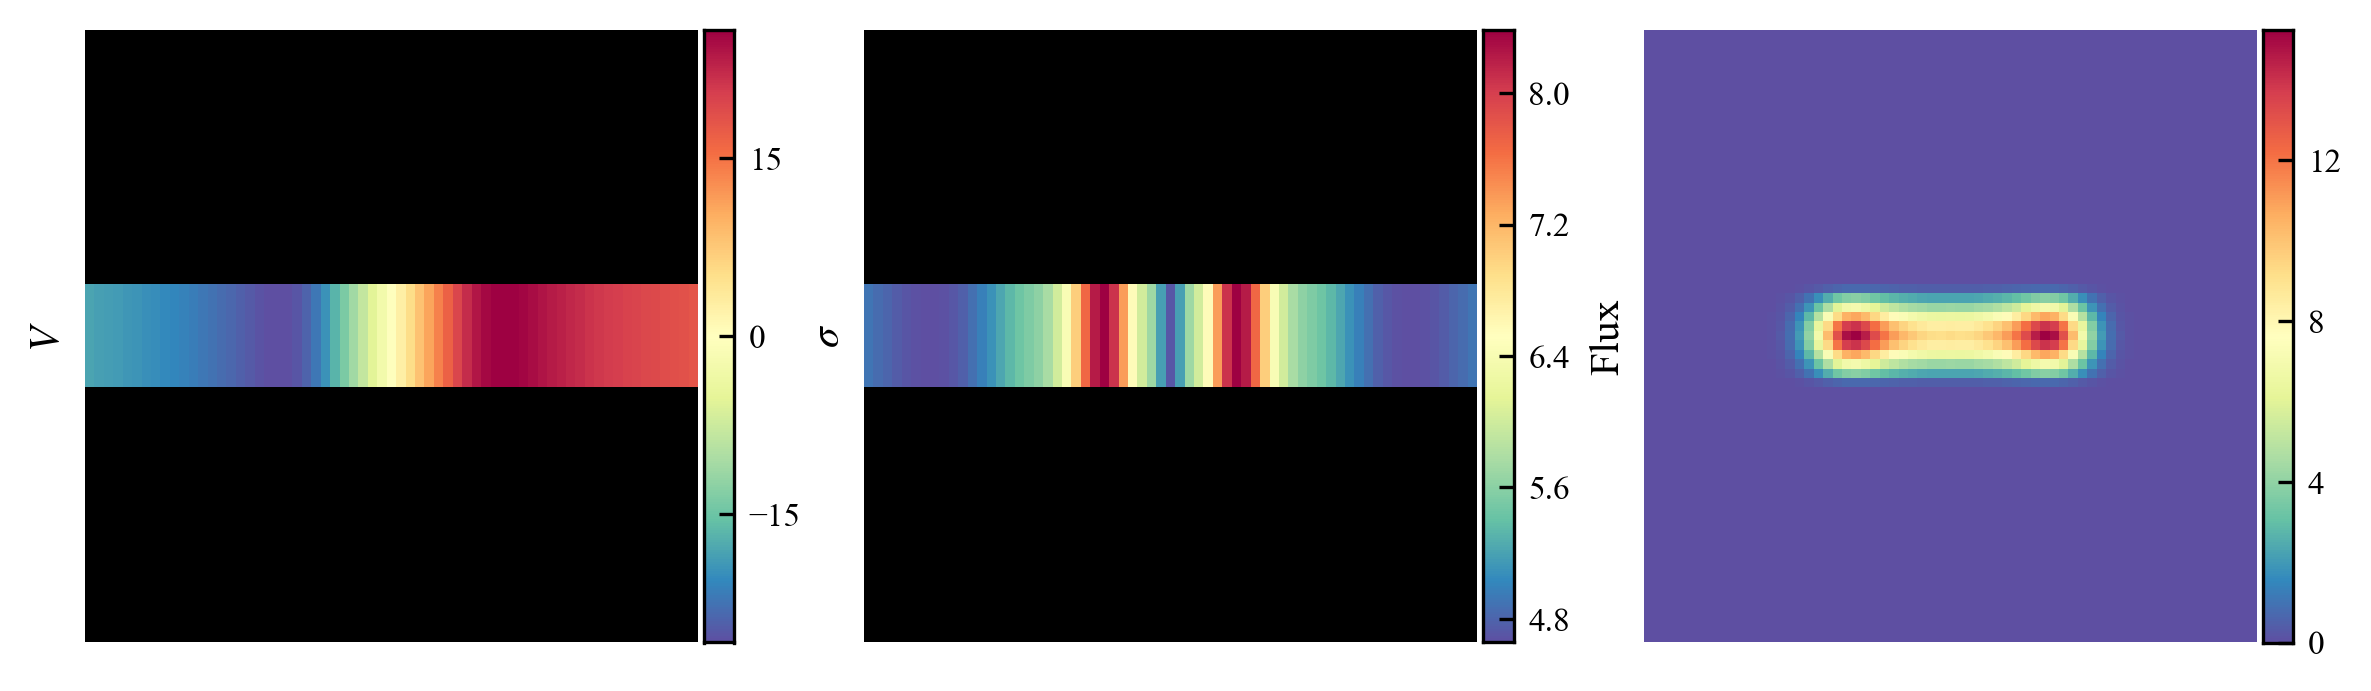

In [251]:
plotting.plot_model_2D(galEO, inst_corr=False, fitflux=True)

### 2D model

In [252]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

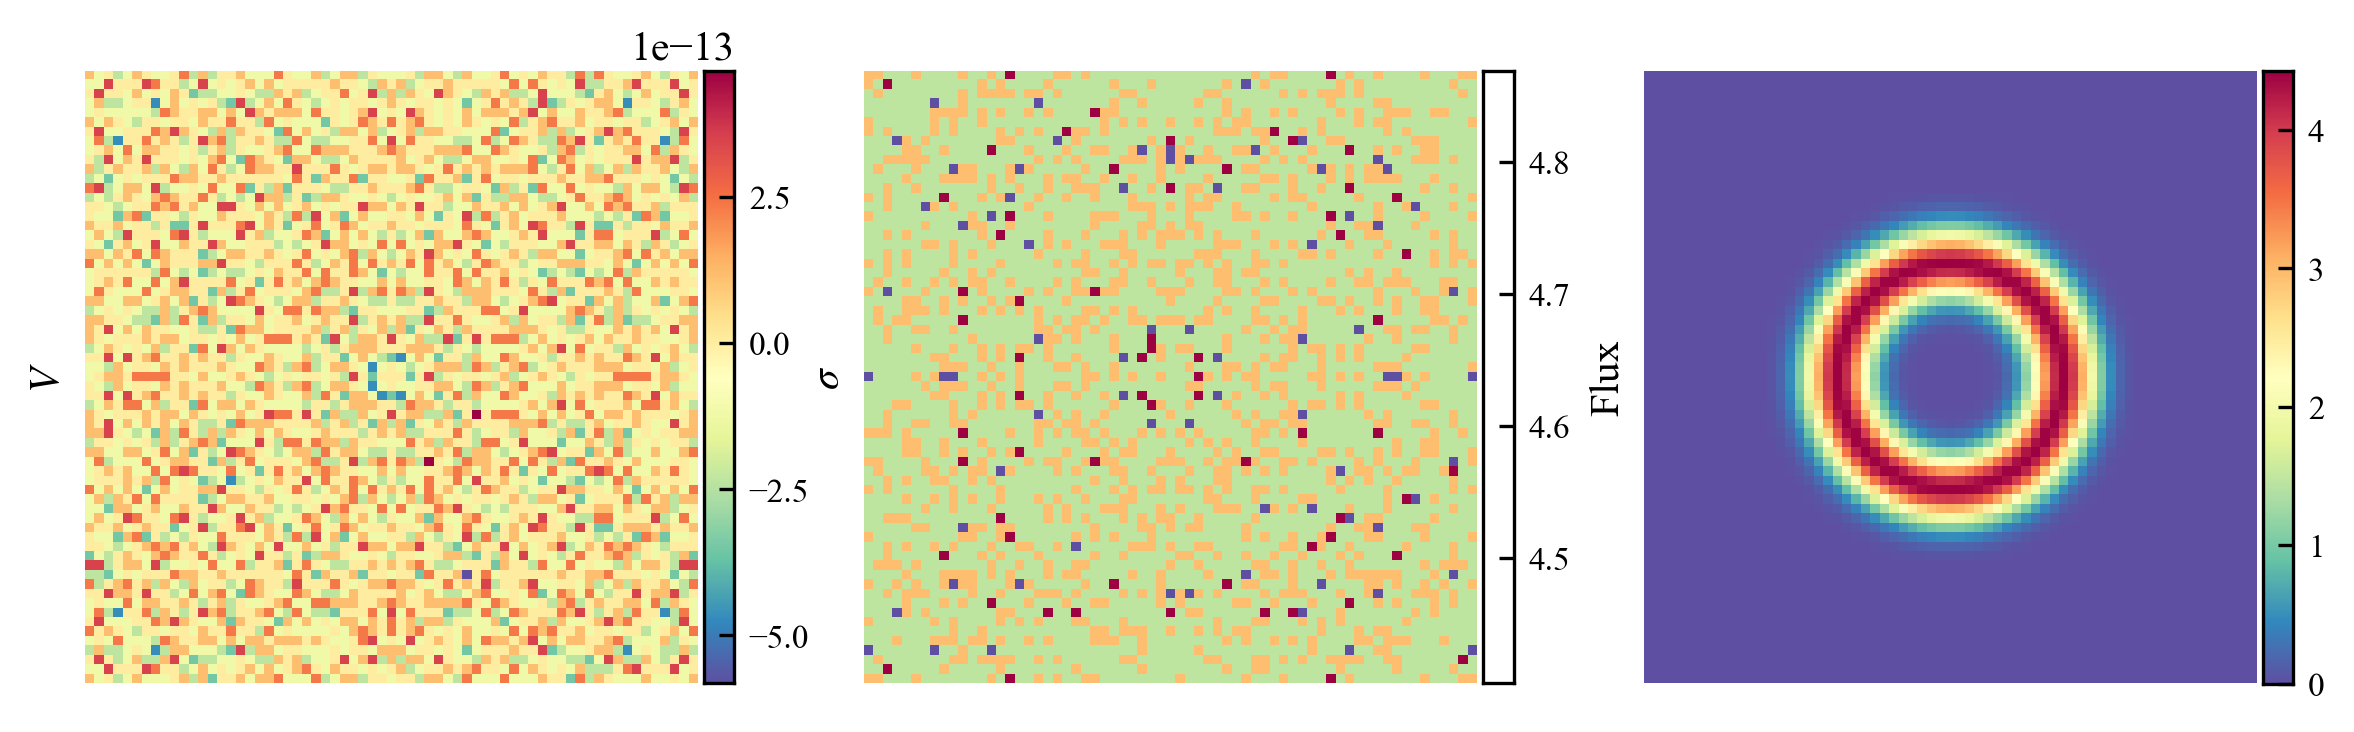

In [253]:
plotting.plot_model_2D(galFO, inst_corr=False, fitflux=True)

---------

--------